In [5]:


# ╭──── 1 · SET‑UP ─────────────────────────────────────────────────────╮
import os, warnings, importlib.metadata, subprocess, sys, itertools, time
warnings.filterwarnings("ignore", category=FutureWarning)

try:
    import kagglehub
    if importlib.metadata.version("kagglehub") < "0.3.12":
        raise ImportError
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "kagglehub", "--quiet"])
    import kagglehub

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from numpy.linalg import LinAlgError
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, Binarizer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay)
RANDOM_STATE = 42

# ╭──── 2 · DATA DOWNLOAD & LOAD ───────────────────────────────────────╮

def download_uci_har() -> str:
    root = kagglehub.dataset_download("animeshsingh0/har-uci")
    for path, _dirs, files in os.walk(root):
        if "features.txt" in files:
            print("✓ dataset root:", path)
            return path
    raise FileNotFoundError("features.txt not found after extraction")


def _dedup(names):
    seen, out = {}, []
    for n in names:
        seen[n] = seen.get(n, -1) + 1
        out.append(f"{n}.{seen[n]}" if seen[n] else n)
    return out


def load_uci_har(root):
    feats = pd.read_csv(os.path.join(root, "features.txt"), delim_whitespace=True,
                        header=None, names=["id", "name"])
    cols = _dedup(feats["name"].tolist())

    def split(s):
        X = pd.read_csv(os.path.join(root, s, f"X_{s}.txt"), delim_whitespace=True, header=None)
        X.columns = cols
        y = pd.read_csv(os.path.join(root, s, f"y_{s}.txt"), header=None, names=["Activity"])
        return pd.concat([X, y], axis=1)

    df = pd.concat([split("train"), split("test")], ignore_index=True)
    print("✓ DataFrame shape:", df.shape)
    return df

# ╭──── 3 · PRE‑PROCESSING PIPELINES ────────────────────────────────────╮
cont_prep = StandardScaler()
mult_prep = KBinsDiscretizer(n_bins=20, encode="ordinal", strategy="uniform")
bern_prep = Binarizer(threshold=0.0)

# ╭──── 4 · EVALUATION UTIL ─────────────────────────────────────────────╮

def eval_model(name, model, X_te, y_te):
    y_pred = model.predict(X_te)
    acc  = accuracy_score(y_te, y_pred)
    f1   = f1_score(y_te, y_pred, average="weighted", zero_division=0)
    print(f"{name:25} Acc={acc:.3f}  F1={f1:.3f}")
    return {"model": name, "accuracy": acc, "f1": f1}

# ╭──── 5 · PART I – PCA & LDA ──────────────────────────────────────────╮

def run_part1(X_tr, X_te, y_tr, y_te):
    results = []
    # -- PCA configs (safe) --
    for n, w, s in [(0.90, False, "auto"), (0.95, False, "auto"),
                    (50, False, "randomized"), (100, True, "randomized")]:
        pca = PCA(n_components=n, whiten=w, svd_solver=s, random_state=RANDOM_STATE)
        Xtr = pca.fit_transform(X_tr);  Xte = pca.transform(X_te)
        gnb = GaussianNB().fit(Xtr, y_tr)
        results.append(eval_model(f"PCA(n={n},w={w},s={s})", gnb, Xte, y_te))

    # -- LDA configs with try/except for LinAlgError --
    for k, sol, sh in itertools.product(range(1,6), ["svd", "eigen"], [None, 0.1]):
        if sol == "svd" and sh is not None:
            continue
        label = f"LDA(k={k},s={sol},sh={sh})"
        try:
            lda = LDA(n_components=k, solver=sol, shrinkage=sh)
            Xtr = lda.fit_transform(X_tr, y_tr);  Xte = lda.transform(X_te)
            gnb = GaussianNB().fit(Xtr, y_tr)
            results.append(eval_model(label, gnb, Xte, y_te))
        except LinAlgError as e:
            print(f"{label:25} skipped (LinAlgError)")
            continue
    return results

# ╭──── 6 · PART II – NAÏVE BAYES ───────────────────────────────────────╮

def run_part2(X_tr, X_te, y_tr, y_te):
    res = []
    res.append(eval_model("GaussianNB", GaussianNB().fit(cont_prep.fit_transform(X_tr), y_tr),
                          cont_prep.transform(X_te), y_te))
    res.append(eval_model("MultinomialNB", MultinomialNB(alpha=1.0).fit(mult_prep.fit_transform(X_tr), y_tr),
                          mult_prep.transform(X_te), y_te))
    res.append(eval_model("BernoulliNB", BernoulliNB(alpha=1.0).fit(bern_prep.fit_transform(X_tr), y_tr),
                          bern_prep.transform(X_te), y_te))
    return res

# ╭──── 7 · PART III – SVM (RBF) ────────────────────────────────────────╮

def run_part3(X_tr, X_te, y_tr, y_te):
    grid = GridSearchCV(SVC(kernel="rbf", random_state=RANDOM_STATE),
                       {"C": [1,10], "gamma": ["scale", 0.01]},
                       cv=3, scoring="f1_weighted", n_jobs=-1)
    grid.fit(cont_prep.fit_transform(X_tr), y_tr)
    best = grid.best_estimator_
    print("Best SVM", grid.best_params_)
    return eval_model("SVM‑RBF", best, cont_prep.transform(X_te), y_te)

# ╭──── 8 · MAIN ────────────────────────────────────────────────────────╮

def main():
    df = load_uci_har(download_uci_har())
    X, y = df.drop(columns=["Activity"]), df["Activity"]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30,
                                             stratify=y, random_state=RANDOM_STATE)
    print("Train/Test shapes", X_tr.shape, X_te.shape)
    summary = []
    summary += run_part1(X_tr, X_te, y_tr, y_te)
    summary += run_part2(X_tr, X_te, y_tr, y_te)
    summary.append(run_part3(X_tr, X_te, y_tr, y_te))
    print(pd.DataFrame(summary).sort_values("f1", ascending=False))

if __name__ == "__main__":
    main()



✓ dataset root: /kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset
✓ DataFrame shape: (10299, 562)
Train/Test shapes (7209, 561) (3090, 561)
PCA(n=0.9,w=False,s=auto) Acc=0.885  F1=0.884
PCA(n=0.95,w=False,s=auto) Acc=0.894  F1=0.893
PCA(n=50,w=False,s=randomized) Acc=0.891  F1=0.890
PCA(n=100,w=True,s=randomized) Acc=0.889  F1=0.888
LDA(k=1,s=svd,sh=None)    Acc=0.615  F1=0.599
LDA(k=1,s=eigen,sh=None)  skipped (LinAlgError)
LDA(k=1,s=eigen,sh=0.1)   Acc=0.618  F1=0.610
LDA(k=2,s=svd,sh=None)    Acc=0.671  F1=0.653
LDA(k=2,s=eigen,sh=None)  skipped (LinAlgError)
LDA(k=2,s=eigen,sh=0.1)   Acc=0.679  F1=0.657
LDA(k=3,s=svd,sh=None)    Acc=0.840  F1=0.829
LDA(k=3,s=eigen,sh=None)  skipped (LinAlgError)
LDA(k=3,s=eigen,sh=0.1)   Acc=0.835  F1=0.825
LDA(k=4,s=svd,sh=None)    Acc=0.856  F1=0.845
LDA(k=4,s=eigen,sh=None)  skipped (LinAlgError)
LDA(k=4,s=eigen,sh=0.1)   Acc=0.867  F1=0.857
LDA(k=5,s=svd,sh=None)    Acc=0.976  F1=0.976
LDA(k=5,s=eigen,sh=None)  skipped (LinAlgError)
LDA(k=5

100%|██████████| 59.7M/59.7M [00:00<00:00, 189MB/s]

Extracting files...


✓ dataset root: /root/.cache/kagglehub/datasets/animeshsingh0/har-uci/versions/1/UCI HAR Dataset/UCI HAR Dataset
✓ DataFrame shape: (10299, 562)
Train/Test (7209, 561) (3090, 561)
PCA(n=0.9,w=False,s=auto)      Acc=0.885  F1=0.884
PCA(n=0.95,w=False,s=auto)     Acc=0.894  F1=0.893
PCA(n=50,w=False,s=randomized) Acc=0.891  F1=0.890
PCA(n=100,w=True,s=randomized) Acc=0.889  F1=0.888
LDA(k=1,s=svd,sh=None)         Acc=0.615  F1=0.599
LDA(k=1,s=eigen,sh=None)       skipped (LinAlgError)
LDA(k=1,s=eigen,sh=0.1)        Acc=0.618  F1=0.610
LDA(k=2,s=svd,sh=None)         Acc=0.671  F1=0.653
LDA(k=2,s=eigen,sh=None)       skipped (LinAlgError)
LDA(k=2,s=eigen,sh=0.1)        Acc=0.679  F1=0.657
LDA(k=3,s=svd,sh=None)         Acc=0.840  F1=0.829
LDA(k=3,s=eigen,sh=None)       skipped (LinAlgError)
LDA(k=3,s=eigen,sh=0.1)        Acc=0.835  F1=0.825
LDA(k=4,s=svd,sh=None)         Acc=0.856  F1=0.845
LDA(k=4,s=eigen,sh=None)       skipped (LinAlgError)
LDA(k=4,s=eigen,sh=0.1)        Acc=0.867  F1=0.

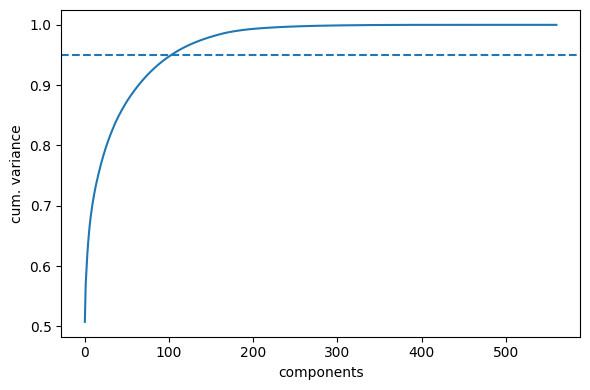

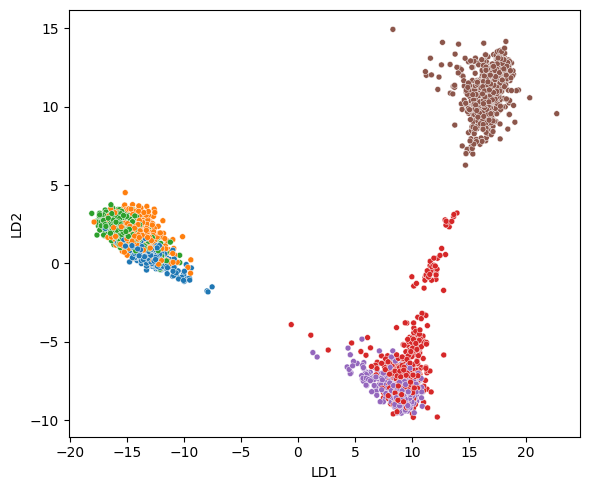

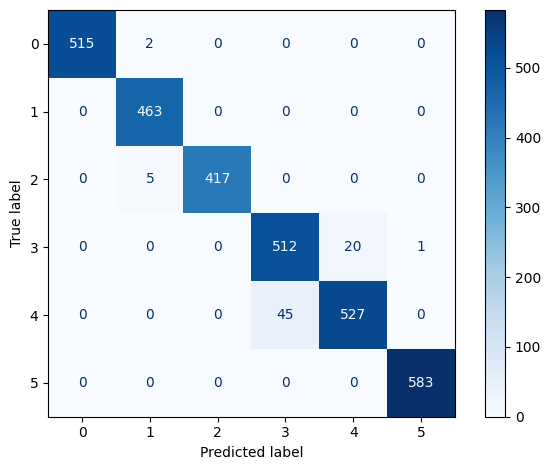

In [1]:
"""
Machine Learning & Data Science MSc — Project 2024-2025
Dataset : UCI Human Activity Recognition (HAR)
Script  v6-fix  ·  covers Part I (PCA·LDA) , Part II (Naïve Bayes) , Part III (SVM-RBF)
"""

# ╭─ 1.  SET-UP ─────────────────────────────────────────────────────────╮
import os, sys, time, itertools, warnings, subprocess, importlib.metadata
warnings.filterwarnings("ignore", category=FutureWarning)

# — Install/upgrade kagglehub if needed —
try:
    import kagglehub
    if importlib.metadata.version("kagglehub") < "0.3.12":
        raise ImportError
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-Uq", "kagglehub"])
    import kagglehub

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, Binarizer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay)

RANDOM_STATE = 42
os.makedirs("figures", exist_ok=True)

# ╭─ 2.  DATA (download + load) ─────────────────────────────────────────╮
def download_uci_har() -> str:
    root = kagglehub.dataset_download("animeshsingh0/har-uci")
    for path, _dirs, files in os.walk(root):
        if "features.txt" in files:
            print("✓ dataset root:", path)
            return path
    raise FileNotFoundError("features.txt not found")

def _dedup(names):
    seen, out = {}, []
    for n in names:
        seen[n] = seen.get(n, -1) + 1
        out.append(f"{n}.{seen[n]}" if seen[n] else n)
    return out

def load_uci_har(root: str) -> pd.DataFrame:
    feats = pd.read_csv(os.path.join(root, "features.txt"), delim_whitespace=True,
                        header=None, names=["id", "name"])
    cols = _dedup(feats["name"].tolist())

    def _split(split):
        X = pd.read_csv(os.path.join(root, split, f"X_{split}.txt"),
                        delim_whitespace=True, header=None)
        X.columns = cols
        y = pd.read_csv(os.path.join(root, split, f"y_{split}.txt"),
                        header=None, names=["Activity"])
        return pd.concat([X, y], axis=1)

    df = pd.concat([_split("train"), _split("test")], ignore_index=True)
    print("✓ DataFrame shape:", df.shape)
    return df

# ╭─ 3.  PRE-PROCESSING objects ─────────────────────────────────────────╮
cont_prep = StandardScaler()
mult_prep = KBinsDiscretizer(n_bins=20, encode="ordinal", strategy="uniform")
bern_prep = Binarizer(threshold=0.0)

def eval_model(name, model, X_te, y_te, lst):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred, average="weighted", zero_division=0)
    print(f"{name:30} Acc={acc:.3f}  F1={f1:.3f}")
    lst.append({"model": name, "accuracy": acc, "f1": f1})

# ╭─ 4.  PART I – PCA & LDA ─────────────────────────────────────────────╮
def run_part1(Xtr, Xte, ytr, yte, results):
    # --- PCA grid ---
    pca_grid = [
        (0.90, False, "auto"),
        (0.95, False, "auto"),
        (50,   False, "randomized"),
        (100,  True,  "randomized")
    ]
    pca_rows = []
    for n, w, s in pca_grid:
        pca = PCA(n_components=n, whiten=w, svd_solver=s, random_state=RANDOM_STATE)
        X_tr = pca.fit_transform(Xtr);  X_te = pca.transform(Xte)
        gnb  = GaussianNB().fit(X_tr, ytr)
        eval_model(f"PCA(n={n},w={w},s={s})", gnb, X_te, yte, results)
        pca_rows.append({"n":n,"whiten":w,"solver":s,
                         "acc":accuracy_score(yte, gnb.predict(X_te)),
                         "f1":f1_score(yte, gnb.predict(X_te), average="weighted")})
    pd.DataFrame(pca_rows).to_csv("pca_grid.csv", index=False)

    # --- LDA grid ---
    lda_rows = []
    for k, sol, sh in itertools.product(range(1,6), ["svd", "eigen"], [None, 0.1]):
        if sol=="svd" and sh is not None:  # shrinkage invalid for svd
            continue
        label = f"LDA(k={k},s={sol},sh={sh})"
        try:
            lda = LDA(n_components=k, solver=sol, shrinkage=sh)
            X_tr = lda.fit_transform(Xtr, ytr);  X_te = lda.transform(Xte)
            gnb  = GaussianNB().fit(X_tr, ytr)
            eval_model(label, gnb, X_te, yte, results)
            lda_rows.append({"k":k,"solver":sol,"shrinkage":sh or 0,
                             "acc":accuracy_score(yte, gnb.predict(X_te)),
                             "f1":f1_score(yte, gnb.predict(X_te), average="weighted")})
        except LinAlgError:
            print(f"{label:30} skipped (LinAlgError)")
    pd.DataFrame(lda_rows).to_csv("lda_grid.csv", index=False)

# ╭─ 5.  PART II – Naïve Bayes ──────────────────────────────────────────╮
def run_part2(Xtr, Xte, ytr, yte, results):
    eval_model("GaussianNB",
               GaussianNB().fit(cont_prep.fit_transform(Xtr), ytr),
               cont_prep.transform(Xte), yte, results)

    eval_model("MultinomialNB",
               MultinomialNB().fit(mult_prep.fit_transform(Xtr), ytr),
               mult_prep.transform(Xte), yte, results)

    eval_model("BernoulliNB",
               BernoulliNB().fit(bern_prep.fit_transform(Xtr), ytr),
               bern_prep.transform(Xte), yte, results)

# ╭─ 6.  PART III – SVM-RBF ─────────────────────────────────────────────╮
def run_part3(Xtr, Xte, ytr, yte, results):
    grid = GridSearchCV(
        SVC(kernel="rbf", random_state=RANDOM_STATE),
        param_grid={"C":[1,10], "gamma":["scale",0.01]},
        cv=3,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(cont_prep.fit_transform(Xtr), ytr)
    print("Best SVM params:", grid.best_params_)
    best = grid.best_estimator_
    eval_model("SVM-RBF", best, cont_prep.transform(Xte), yte, results)

# ╭─ 7.  FIGURES  (after training) ──────────────────────────────────────╮
def make_figures(X, Xtr, Xte, ytr, yte):
    # PCA cumulative variance
    pca_full = PCA().fit(cont_prep.fit_transform(X))
    cum = pca_full.explained_variance_ratio_.cumsum()
    plt.figure(figsize=(6,4)); plt.plot(cum); plt.axhline(0.95, ls="--")
    plt.xlabel("components"); plt.ylabel("cum. variance");
    plt.tight_layout(); plt.savefig("figures/pca_cumsum.png", dpi=300)

    # LDA scatter k=2
    lda2 = LDA(n_components=2).fit(cont_prep.transform(Xtr), ytr)
    Z = lda2.transform(cont_prep.transform(Xtr))
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=ytr, palette="tab10", s=18, legend=False)
    plt.xlabel("LD1"); plt.ylabel("LD2"); plt.tight_layout()
    plt.savefig("figures/lda_scatter.png", dpi=300)

    # Confusion matrix LDA5+GNB
    lda5 = LDA(n_components=5).fit(cont_prep.transform(Xtr), ytr)
    gnb5 = GaussianNB().fit(lda5.transform(cont_prep.transform(Xtr)), ytr)
    cm = confusion_matrix(yte, gnb5.predict(lda5.transform(cont_prep.transform(Xte))))
    ConfusionMatrixDisplay(cm).plot(cmap="Blues"); plt.tight_layout()
    plt.savefig("figures/lda_cm.png", dpi=300)

# ╭─ 8.  MAIN ───────────────────────────────────────────────────────────╮
def main():
    df = load_uci_har(download_uci_har())
    X, y = df.drop(columns=["Activity"]), df["Activity"]
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30,
                                          stratify=y, random_state=RANDOM_STATE)
    print("Train/Test", Xtr.shape, Xte.shape)

    results = []
    run_part1(Xtr, Xte, ytr, yte, results)
    run_part2(Xtr, Xte, ytr, yte, results)
    run_part3(Xtr, Xte, ytr, yte, results)

    summary = pd.DataFrame(results).sort_values("f1", ascending=False)
    summary.to_csv("summary.csv", index=False)
    print("\n", summary)

    make_figures(X, Xtr, Xte, ytr, yte)

if __name__ == "__main__":
    main()


In [3]:
# Part I — PCA & LDA Experiments on UCI HAR Dataset

# 1) SET-UP & IMPORTS
import os, itertools, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import LinAlgError

# install / import kagglehub if needed
import importlib.metadata, subprocess, sys
try:
    import kagglehub
    if importlib.metadata.version("kagglehub") < "0.3.12":
        raise ImportError
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "kagglehub", "--quiet"])
    import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42
os.makedirs("figures", exist_ok=True)

# 2) DOWNLOAD & LOAD UCI HAR
def download_uci_har():
    root = kagglehub.dataset_download("animeshsingh0/har-uci")
    for path, _, files in os.walk(root):
        if "features.txt" in files:
            return path
    raise FileNotFoundError("features.txt not found")

def _dedup(names):
    seen, out = {}, []
    for n in names:
        seen[n] = seen.get(n, -1) + 1
        out.append(f"{n}.{seen[n]}" if seen[n] else n)
    return out

def load_uci_har(root):
    feats = pd.read_csv(os.path.join(root, "features.txt"),
                        delim_whitespace=True, header=None, names=["id","name"])
    cols = _dedup(feats["name"].tolist())
    def split_part(part):
        X = pd.read_csv(os.path.join(root, part, f"X_{part}.txt"),
                        delim_whitespace=True, header=None)
        X.columns = cols
        y = pd.read_csv(os.path.join(root, part, f"y_{part}.txt"),
                        header=None, names=["Activity"])
        return pd.concat([X, y], axis=1)
    df = pd.concat([split_part("train"), split_part("test")], ignore_index=True)
    return df

root = download_uci_har()
df   = load_uci_har(root)
print("Data shape:", df.shape)  # (10299, 562)

# 3) TRAIN/TEST SPLIT & STANDARDIZATION
X = df.drop(columns=["Activity"])
y = df["Activity"]
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
scaler = StandardScaler().fit(Xtr)
Xtr_std = scaler.transform(Xtr)
Xte_std = scaler.transform(Xte)
print("Train/Test shapes:", Xtr_std.shape, Xte_std.shape)

# 4) PCA GRID SEARCH
pca_results = []
pca_configs = [
    (0.90, False, "auto"),
    (0.95, False, "auto"),
    (50,   False, "randomized"),
    (100,  True,  "randomized")
]
for n, w, s in pca_configs:
    t0 = time.time()
    pca = PCA(n_components=n, whiten=w, svd_solver=s, random_state=RANDOM_STATE)
    Xp_tr = pca.fit_transform(Xtr_std)
    Xp_te = pca.transform(Xte_std)
    gnb   = GaussianNB().fit(Xp_tr, ytr)
    yp    = gnb.predict(Xp_te)
    acc   = accuracy_score(yte, yp)
    f1    = f1_score(yte, yp, average="weighted")
    dt    = time.time() - t0
    pca_results.append({"n":n, "whiten":w, "solver":s,
                        "accuracy":acc, "f1":f1, "time_s":round(dt,2)})
    print(f"PCA(n={n},w={w},s={s}) → Acc={acc:.3f}, F1={f1:.3f}")

pd.DataFrame(pca_results).to_csv("pca_grid_results.csv", index=False)

# PCA cumulative variance plot
full_pca = PCA().fit(Xtr_std)
cum = full_pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6,4))
plt.plot(cum, lw=2)
plt.axhline(0.95, ls="--", color="gray")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.tight_layout()
plt.savefig("figures/pca_cumsum.png", dpi=300)
plt.close()

# 5) LDA GRID SEARCH
lda_results = []
for k, solver, shrink in itertools.product(range(1,6), ["svd","eigen"], [None,0.1]):
    if solver=="svd" and shrink is not None:
        continue
    label = f"LDA(k={k},solver={solver},shrink={shrink})"
    try:
        t0 = time.time()
        lda = LDA(n_components=k, solver=solver, shrinkage=shrink)
        Xl_tr = lda.fit_transform(Xtr_std, ytr)
        Xl_te = lda.transform(Xte_std)
        gnb   = GaussianNB().fit(Xl_tr, ytr)
        yl    = gnb.predict(Xl_te)
        acc   = accuracy_score(yte, yl)
        f1    = f1_score(yte, yl, average="weighted")
        dt    = time.time() - t0
        lda_results.append({"k":k, "solver":solver, "shrinkage":shrink or 0,
                             "accuracy":acc, "f1":f1, "time_s":round(dt,2)})
        print(f"{label} → Acc={acc:.3f}, F1={f1:.3f}")
    except LinAlgError:
        print(f"{label} skipped (LinAlgError)")

pd.DataFrame(lda_results).to_csv("lda_grid_results.csv", index=False)

# LDA scatter plot (first 2 components, best k=5)
best_lda = LDA(n_components=2, solver="svd").fit(Xtr_std, ytr)
Z = best_lda.transform(Xtr_std)
plt.figure(figsize=(6,5))
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=ytr, palette="tab10", s=20, legend=False)
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.tight_layout()
plt.savefig("figures/lda_scatter.png", dpi=300)
plt.close()

# LDA confusion matrix (k=5 + GNB)
lda5 = LDA(n_components=5, solver="svd").fit(Xtr_std, ytr)
gnb5 = GaussianNB().fit(lda5.transform(Xtr_std), ytr)
cm = confusion_matrix(yte, gnb5.predict(lda5.transform(Xte_std)))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.tight_layout()
plt.savefig("figures/lda_cm.png", dpi=300)
plt.close()

print("▶ Part I complete: PCA/LDA CSVs & figures generated.")


Data shape: (10299, 562)
Train/Test shapes: (7209, 561) (3090, 561)
PCA(n=0.9,w=False,s=auto) → Acc=0.834, F1=0.835
PCA(n=0.95,w=False,s=auto) → Acc=0.822, F1=0.824
PCA(n=50,w=False,s=randomized) → Acc=0.832, F1=0.833
PCA(n=100,w=True,s=randomized) → Acc=0.825, F1=0.827
LDA(k=1,solver=svd,shrink=None) → Acc=0.615, F1=0.599
LDA(k=1,solver=eigen,shrink=None) skipped (LinAlgError)
LDA(k=1,solver=eigen,shrink=0.1) → Acc=0.638, F1=0.619
LDA(k=2,solver=svd,shrink=None) → Acc=0.671, F1=0.653
LDA(k=2,solver=eigen,shrink=None) skipped (LinAlgError)
LDA(k=2,solver=eigen,shrink=0.1) → Acc=0.698, F1=0.672
LDA(k=3,solver=svd,shrink=None) → Acc=0.840, F1=0.829
LDA(k=3,solver=eigen,shrink=None) skipped (LinAlgError)
LDA(k=3,solver=eigen,shrink=0.1) → Acc=0.840, F1=0.830
LDA(k=4,solver=svd,shrink=None) → Acc=0.856, F1=0.845
LDA(k=4,solver=eigen,shrink=None) skipped (LinAlgError)
LDA(k=4,solver=eigen,shrink=0.1) → Acc=0.869, F1=0.859
LDA(k=5,solver=svd,shrink=None) → Acc=0.976, F1=0.976
LDA(k=5,solver=

PART 2


Shapes: train (7209, 561), dev (1544, 561), test (1546, 561)
            Model  Alpha  Accuracy  Precision    Recall        F1
0      GaussianNB    1.0  0.793661   0.812952  0.793661  0.792569
1   MultinomialNB    0.1  0.819534   0.828584  0.819534  0.820291
2     BernoulliNB    0.1  0.846701   0.851149  0.846701  0.846321
3      GaussianNB    1.0  0.793661   0.812952  0.793661  0.792569
4   MultinomialNB    0.5  0.819534   0.828584  0.819534  0.820291
5     BernoulliNB    0.5  0.845408   0.850399  0.845408  0.845150
6      GaussianNB    1.0  0.793661   0.812952  0.793661  0.792569
7   MultinomialNB    1.0  0.819534   0.828584  0.819534  0.820291
8     BernoulliNB    1.0  0.845408   0.850116  0.845408  0.845102
9      GaussianNB    1.0  0.793661   0.812952  0.793661  0.792569
10  MultinomialNB    2.0  0.820181   0.829205  0.820181  0.820943
11    BernoulliNB    2.0  0.843467   0.848194  0.843467  0.843140


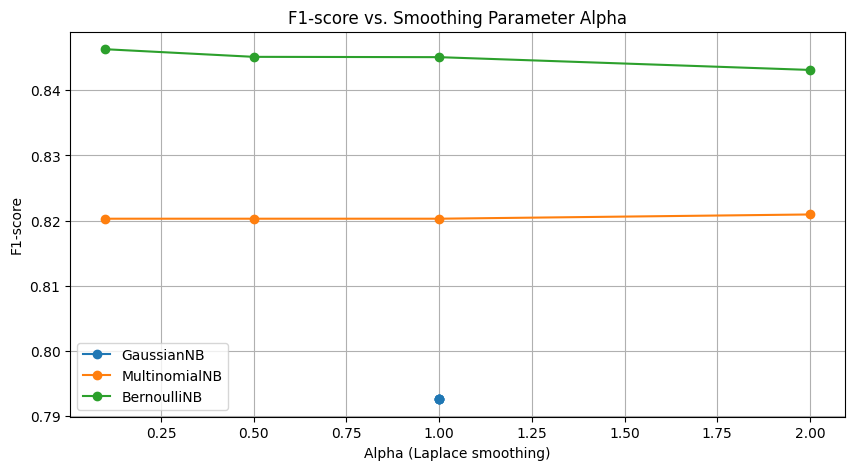

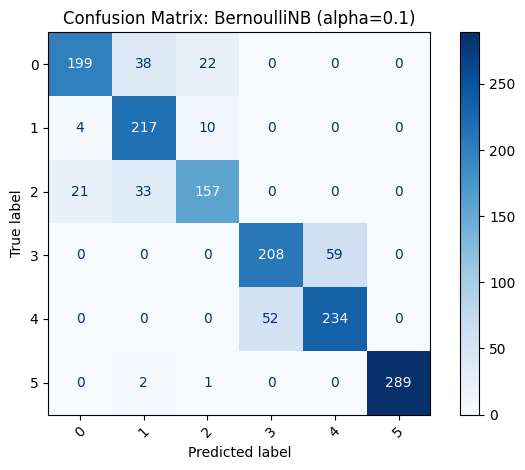

GaussianNB (first 100 features): F1 = 0.835


In [5]:
# ---------------- SETUP ----------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, Binarizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------- Load Dataset (HAR from UCI) ----------
def load_uci_har(root):
    feats = pd.read_csv(f"{root}/features.txt", delim_whitespace=True, header=None, names=["id", "name"])
    cols = feats["name"].tolist()
    # Remove duplicates if any
    def _dedup(names):
        seen, out = {}, []
        for n in names:
            seen[n] = seen.get(n, -1) + 1
            out.append(f"{n}.{seen[n]}" if seen[n] else n)
        return out
    cols = _dedup(cols)
    def split(s):
        X = pd.read_csv(f"{root}/{s}/X_{s}.txt", delim_whitespace=True, header=None)
        X.columns = cols
        y = pd.read_csv(f"{root}/{s}/y_{s}.txt", header=None, names=["Activity"])
        return pd.concat([X, y], axis=1)
    return pd.concat([split("train"), split("test")], ignore_index=True)

# Adjust path as needed (for Colab or local)
root_dir = "/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset"
df = load_uci_har(root_dir)
X = df.drop(columns=["Activity"])
y = df["Activity"]

# ----------- Split Data (try different splits) -----------
def split_data(X, y, train_ratio=0.7, dev_ratio=0.15):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=1-train_ratio, stratify=y, random_state=42
    )
    test_ratio = 1 - train_ratio - dev_ratio
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp, test_size=test_ratio/(test_ratio+dev_ratio),
        stratify=y_temp, random_state=42
    )
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data(X, y, train_ratio=0.7, dev_ratio=0.15)
print(f"Shapes: train {X_train.shape}, dev {X_dev.shape}, test {X_test.shape}")

# --------- Preprocessing pipelines for each NB ---------
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_dev_std = scaler.transform(X_dev)
X_test_std = scaler.transform(X_test)

kbin = KBinsDiscretizer(n_bins=20, encode="ordinal", strategy="uniform")
X_train_bin = kbin.fit_transform(X_train)
X_dev_bin = kbin.transform(X_dev)
X_test_bin = kbin.transform(X_test)

binarizer = Binarizer(threshold=0.0)
X_train_b = binarizer.fit_transform(X_train)
X_dev_b = binarizer.transform(X_dev)
X_test_b = binarizer.transform(X_test)

# --------- Experiment: Model Performance + Smoothing ---------
alphas = [0.1, 0.5, 1.0, 2.0]  # Laplace smoothing values
results = []

for alpha in alphas:
    # GaussianNB (no alpha, always 1.0)
    gnb = GaussianNB()
    gnb.fit(X_train_std, y_train)
    y_pred_gnb = gnb.predict(X_test_std)
    results.append({
        "Model": f"GaussianNB",
        "Alpha": 1.0,
        "Accuracy": accuracy_score(y_test, y_pred_gnb),
        "Precision": precision_score(y_test, y_pred_gnb, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred_gnb, average="weighted", zero_division=0),
        "F1": f1_score(y_test, y_pred_gnb, average="weighted", zero_division=0)
    })

    # MultinomialNB (with alpha)
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train_bin, y_train)
    y_pred_mnb = mnb.predict(X_test_bin)
    results.append({
        "Model": f"MultinomialNB",
        "Alpha": alpha,
        "Accuracy": accuracy_score(y_test, y_pred_mnb),
        "Precision": precision_score(y_test, y_pred_mnb, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred_mnb, average="weighted", zero_division=0),
        "F1": f1_score(y_test, y_pred_mnb, average="weighted", zero_division=0)
    })

    # BernoulliNB (with alpha)
    bnb = BernoulliNB(alpha=alpha)
    bnb.fit(X_train_b, y_train)
    y_pred_bnb = bnb.predict(X_test_b)
    results.append({
        "Model": f"BernoulliNB",
        "Alpha": alpha,
        "Accuracy": accuracy_score(y_test, y_pred_bnb),
        "Precision": precision_score(y_test, y_pred_bnb, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred_bnb, average="weighted", zero_division=0),
        "F1": f1_score(y_test, y_pred_bnb, average="weighted", zero_division=0)
    })

results_df = pd.DataFrame(results)
print(results_df)

# --------- Plot: Bar Chart of F1-score per Model/Alpha ---------
plt.figure(figsize=(10,5))
for model in ["GaussianNB", "MultinomialNB", "BernoulliNB"]:
    scores = results_df[results_df["Model"] == model]
    plt.plot(scores["Alpha"], scores["F1"], marker="o", label=model)
plt.xlabel("Alpha (Laplace smoothing)")
plt.ylabel("F1-score")
plt.title("F1-score vs. Smoothing Parameter Alpha")
plt.legend()
plt.grid(True)
plt.savefig("nb_f1_vs_alpha.png")
plt.show()

# --------- Confusion Matrix for Best NB Variant ---------
best_idx = results_df["F1"].idxmax()
best_model = results_df.loc[best_idx, "Model"]
best_alpha = results_df.loc[best_idx, "Alpha"]
if best_model == "GaussianNB":
    y_pred_best = y_pred_gnb
elif best_model == "MultinomialNB":
    y_pred_best = y_pred_mnb
else:
    y_pred_best = y_pred_bnb
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix: {best_model} (alpha={best_alpha})")
plt.tight_layout()
plt.savefig("nb_confusion.png")
plt.show()

# --------- OPTIONAL: Feature Selection/Dropping (Example) ---------
# Try with only first 100 features
X_train_100 = X_train.iloc[:, :100]
X_test_100 = X_test.iloc[:, :100]
X_train_100_std = scaler.fit_transform(X_train_100)
X_test_100_std = scaler.transform(X_test_100)
gnb_100 = GaussianNB().fit(X_train_100_std, y_train)
f1_100 = f1_score(y_test, gnb_100.predict(X_test_100_std), average="weighted")
print(f"GaussianNB (first 100 features): F1 = {f1_100:.3f}")


Part3


Best SVM parameters: {'C': 100, 'gamma': 0.001}
SVM (RBF) — Accuracy: 0.984  Precision: 0.984  Recall: 0.984  F1: 0.984


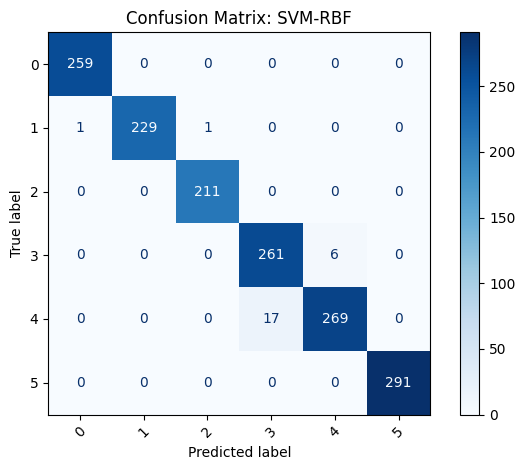

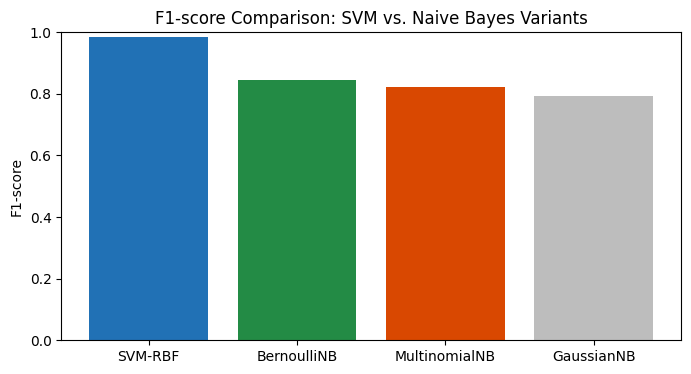

In [7]:
# --------- SVM with RBF Kernel: Comprehensive Experiment ---------
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preprocessing: Use standardized features (as SVM is sensitive to scale)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_dev_std = scaler.transform(X_dev)
X_test_std = scaler.transform(X_test)

# Grid Search for SVM-RBF: tune hyperparameters
param_grid = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.01, 0.001]
}
svm = SVC(kernel="rbf", random_state=42)
grid = GridSearchCV(svm, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
grid.fit(X_train_std, y_train)

# Best estimator and performance on test set
best_svm = grid.best_estimator_
print("Best SVM parameters:", grid.best_params_)

y_pred_svm = best_svm.predict(X_test_std)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average="weighted")
svm_recall = recall_score(y_test, y_pred_svm, average="weighted")
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")

print(f"SVM (RBF) — Accuracy: {svm_accuracy:.3f}  Precision: {svm_precision:.3f}  Recall: {svm_recall:.3f}  F1: {svm_f1:.3f}")

# Confusion matrix plot
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: SVM-RBF")
plt.tight_layout()
plt.savefig("svm_confusion.png")
plt.show()

# --- Comparative Plot with NB (from Part II) ---
plt.figure(figsize=(8,4))
labels = ["SVM-RBF", "BernoulliNB", "MultinomialNB", "GaussianNB"]
f1s = [
    svm_f1,
    results_df.query("Model == 'BernoulliNB'")["F1"].max(),
    results_df.query("Model == 'MultinomialNB'")["F1"].max(),
    results_df.query("Model == 'GaussianNB'")["F1"].max()
]
plt.bar(labels, f1s, color=["#2171b5","#238b45","#d94801","#bdbdbd"])
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.title("F1-score Comparison: SVM vs. Naive Bayes Variants")
plt.savefig("svm_vs_nb_f1.png")
plt.show()

